In [137]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation

In [138]:
from PIL import Image

def image_to_np(impath):
  image = Image.open(impath)
  gray_image = image.convert('L')
  image_array = np.array(gray_image, dtype='float32')
  image_array /= image_array.sum()
  return image_array

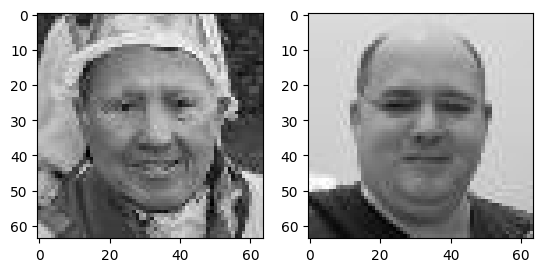

In [139]:
n = 64  # nb bins

# bin positions
x = np.arange(n, dtype=np.float32)
y = np.arange(n, dtype=np.float32)

a = image_to_np('/Users/balazsmorvay/Documents/Azure VM/facediffusion/Coginfocom/images-ema/995.jpeg')
b = image_to_np('/Users/balazsmorvay/Documents/Azure VM/facediffusion/Coginfocom/images-ema/992.jpeg')

sz = a.shape[0]

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(a, cmap='gray')
axarr[1].imshow(b, cmap='gray')
plt.show()

In [158]:
device = "cpu"

# use pyTorch for our data
x1_torch = torch.tensor(a, dtype=torch.float32).to(device=device).requires_grad_(True)
x2_torch = torch.tensor(b, dtype=torch.float32).to(device=device)

lr = 8e-1
nb_iter_max = 500

x_all = np.zeros((nb_iter_max, a.shape[0], a.shape[0]))

loss_iter = []

# generator for random permutations
gen = torch.Generator(device=device)
gen.manual_seed(42)

for i in range(nb_iter_max):

    loss = ot.sliced_wasserstein_distance(x1_torch, x2_torch, n_projections=240, seed=gen)

    loss_iter.append(loss.clone().detach().cpu().numpy())
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1_torch.grad
        x1_torch -= grad * lr / (1 + i / 5e1) # step
        x1_torch.grad.zero_()
        x_all[i, :, :] = x1_torch.clone().detach().cpu().numpy()

xb = x1_torch.clone().detach().cpu().numpy()


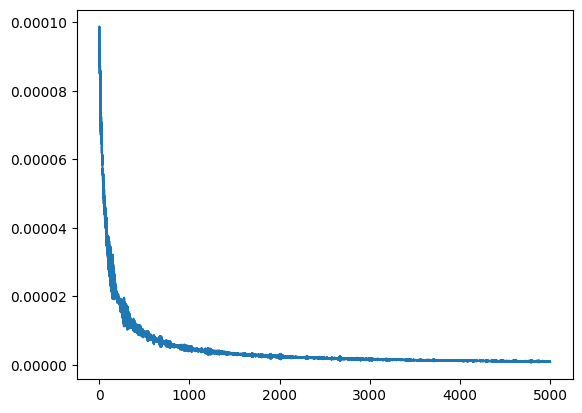

In [159]:
plt.plot(loss_iter)
plt.show()

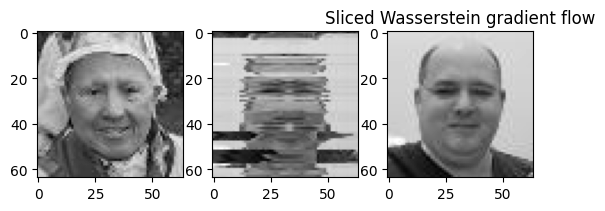

In [160]:
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(a, cmap='gray')
axarr[1].imshow(xb, cmap='gray')
axarr[2].imshow(b, cmap='gray')
pl.title('Sliced Wasserstein gradient flow')
plt.show()

In [149]:
ot.sliced_wasserstein_distance(torch.tensor(a, dtype=torch.float32).to(device=device).requires_grad_(True),
                               torch.tensor(b, dtype=torch.float32).to(device=device),
                               n_projections=20,
                               seed=gen)

tensor(8.7724e-05, grad_fn=<PowBackward0>)

In [150]:
ot.sliced_wasserstein_distance(torch.tensor(xb, dtype=torch.float32).to(device=device).requires_grad_(True),
                               torch.tensor(b, dtype=torch.float32).to(device=device),
                               n_projections=20,
                               seed=gen)

tensor(8.8712e-07, grad_fn=<PowBackward0>)

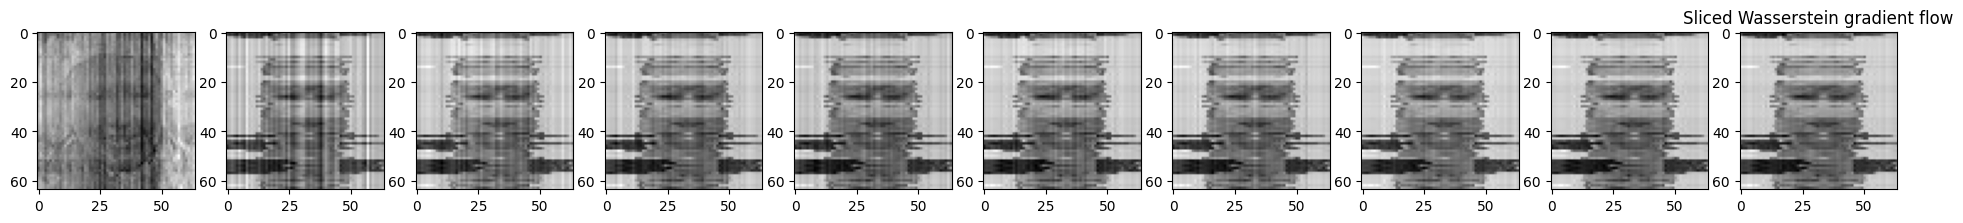

In [151]:
f, axarr = plt.subplots(1, 10, figsize=(24, 24))
for i in range(10):
    axarr[i].imshow(x_all[i*100, :, :], cmap='gray')

pl.title('Sliced Wasserstein gradient flow')
plt.show()